In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

data= pd.read_csv("/content/drive/MyDrive/Cyberbullying_Kaggle_Data/cyberbullying_tweets.csv")

In [57]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


**Phase 1: EDA to see distribution of** **Tweets**

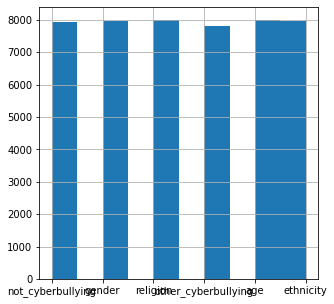

In [58]:
#Distribution of tweets
data.cyberbullying_type.hist() #Histogram shows that the dataset is balanced and has equal representation for all labels

In [59]:
temp = data.groupby('cyberbullying_type').count().reset_index().sort_values(by='tweet_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,cyberbullying_type,tweet_text
5,religion,7998
0,age,7992
2,gender,7973
1,ethnicity,7961
3,not_cyberbullying,7945
4,other_cyberbullying,7823


In [60]:
#Funnel-Chart for better visualization
from plotly import graph_objs as go
fig = go.Figure(go.Funnelarea(
    text =temp,
    values = temp.tweet_text,
    title = {"position": "top center", "text": "Funnel-Chart of Bullying Type Distribution"}
    ))
fig.show()

**Word Cloud of tweets for EDA**

In [61]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [62]:
text = " ".join(review for review in data.tweet_text)

# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update([])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

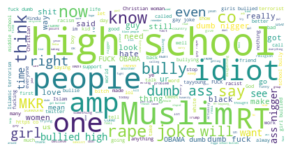

In [63]:
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

**Phase 2: Building a base model for multi-class classification**

**TEXT PREPROCESSING** functions defintion:

In [64]:
# import TweetTokenizer() method from nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Create a reference variable for Class WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Create a reference variable for Class TweetTokenizer
tk = TweetTokenizer()

#Preprocessing: Tweet Tokenizer + lowercase conversion
def LC_tokeniser(df):
  df["tokens"]= df["tweet_text"].apply(lambda x: tk.tokenize(x.lower()))
  return df
#Recover Hashtags
def hashtag(df):
  df["hastags"]= df["tokens"].apply(lambda x: [item for item in x if item.startswith("#")])
  return df
#Recover Mentions @
def mentions(df):
  df["mentions"]= df["tokens"].apply(lambda x: [item for item in x if item.startswith("@")])
  return df
#number of words in a tweet
def length(df):
  df["length"]= df["tokens"].apply(lambda x: len(x))
  return df

#Remove Stop-words
def remove_stopwords(df):
  df['remove_stopwords'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop_words])
  return df

#Lemmatisation to get root words and remove numbers if any!
def lemmatise(df):
  df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x if y.isalpha()]) 
  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [65]:
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [66]:
#Function definition for Topic Modelling based on tweet's comments
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def LDA(df, n=10):
  # initisalise LDA Model
  lda_model = LatentDirichletAllocation(n_components = n, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )
  vectors = []
  for index, row in data.iterrows():
    vectors.append(", ".join(row[6]))
  
  vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))
  vectorised = vectorizer.fit_transform(vectors)
  
  lda_output = lda_model.fit_transform(vectorised)

# column names
  topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe
  df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document
  dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
  df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes
  df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
  df['Dominant_topic']=df['Dominant_topic'].astype(int)

  return df

In [67]:
#Bag of Vectors
from sklearn.feature_extraction.text import CountVectorizer
def bow(df):
  vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))
  # join the processed data to be vectorised
  vectors = []
  for index, row in data.iterrows():
    vectors.append(", ".join(row[6]))

  vectorised = vectorizer.fit_transform(vectors)
  return vectorised

Feature Engineering - BOWs and TF-IDF

In [68]:
'''from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

Model1 = Pipeline([("Lower_case_Tokenizer",LC_tokeniser()),("Getting_Hashtags",hastag()),("length_of_tweet",length()),("RemoveStopWords", remove_stopwords()),("Lemmatise",lemmatise()),("tfidf", TfidfVectorizer()),("clf", MultinomialNB())])
Model1.fit(x_train, y_train)
Model1.score(x_test, y_test)
'''

'from sklearn.naive_bayes import MultinomialNB\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\nModel1 = Pipeline([("Lower_case_Tokenizer",LC_tokeniser()),("Getting_Hashtags",hastag()),("length_of_tweet",length()),("RemoveStopWords", remove_stopwords()),("Lemmatise",lemmatise()),("tfidf", TfidfVectorizer()),("clf", MultinomialNB())])\nModel1.fit(x_train, y_train)\nModel1.score(x_test, y_test)\n'

**Feature Engineering**

Split data into train and test

In [69]:
from sklearn.model_selection import train_test_split
df= LC_tokeniser(data)
df= hashtag(df)
df= mentions(df)
df= length(df)
df= remove_stopwords(df)
df= lemmatise(df)
df["hashtags_present"]=df["hastags"].apply(lambda x: int((len(x)>0)))
df["mentions_present"]= df["mentions"].apply(lambda x:int((len(x)>0)))
df.head()

,tweet_text,cyberbullying_type,tokens,hastags,mentions,length,remove_stopwords,lemmatise,hashtags_present,mentions_present
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",[],11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]",1,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",[],15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white],1,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],[@xochitlsuckkks],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]",0,1
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],[@jason_gio],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,...",0,1
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[@rudhoeenglish, this, is, an, isis, account, ...",[],[@rudhoeenglish],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l...",0,1


In [70]:
df= LDA(df)

In [71]:
df["lemma_sentence"]= df["lemmatise"].apply(lambda x: " ".join(str(w) for w in x))
df.head()

,tweet_text,cyberbullying_type,tokens,hastags,mentions,length,remove_stopwords,lemmatise,hashtags_present,mentions_present,...,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Dominant_topic,lemma_sentence
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"[in, other, words, #katandandre, ,, your, food...","[#katandandre, #mkr]",[],11,"[words, #katandandre, ,, food, crapilicious, !...","[word, food, crapilicious]",1,0,...,0.01,0.01,0.01,0.01,0.01,0.01,0.91,0.01,9,word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,"[why, is, #aussietv, so, white, ?, #mkr, #theb...","[#aussietv, #mkr, #theblock, #imacelebrityau, ...",[],15,"[#aussietv, white, ?, #mkr, #theblock, #imacel...",[white],1,0,...,0.00,0.96,0.00,0.00,0.00,0.00,0.00,0.00,4,white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,"[@xochitlsuckkks, a, classy, whore, ?, or, mor...",[],[@xochitlsuckkks],11,"[@xochitlsuckkks, classy, whore, ?, red, velve...","[classy, whore, red, velvet, cupcake]",0,1,...,0.01,0.01,0.92,0.01,0.01,0.01,0.01,0.01,5,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"[@jason_gio, meh, ., :p, thanks, for, the, hea...",[],[@jason_gio],21,"[@jason_gio, meh, ., :p, thanks, heads, ,, con...","[meh, thanks, head, concerned, another, angry,...",0,1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,"[@rudhoeenglish, this, is, an, isis, account, ...",[],[@rudhoeenglish],21,"[@rudhoeenglish, isis, account, pretending, ku...","[isi, account, pretending, kurdish, account, l...",0,1,...,0.01,0.95,0.01,0.01,0.01,0.01,0.01,0.01,4,isi account pretending kurdish account like is...


In [72]:
print("Duplicate tweets:",df["lemma_sentence"].duplicated().sum())
df.drop_duplicates("lemma_sentence", inplace=True)

Duplicate tweets: 3312


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44380 entries, 0 to 47691
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_text          44380 non-null  object 
 1   cyberbullying_type  44380 non-null  object 
 2   tokens              44380 non-null  object 
 3   hastags             44380 non-null  object 
 4   mentions            44380 non-null  object 
 5   length              44380 non-null  int64  
 6   remove_stopwords    44380 non-null  object 
 7   lemmatise           44380 non-null  object 
 8   hashtags_present    44380 non-null  int64  
 9   mentions_present    44380 non-null  int64  
 10  Topic1              44380 non-null  float64
 11  Topic2              44380 non-null  float64
 12  Topic3              44380 non-null  float64
 13  Topic4              44380 non-null  float64
 14  Topic5              44380 non-null  float64
 15  Topic6              44380 non-null  float64
 16  Topi

In [74]:
x = df.iloc[:,2:22]
y = df['cyberbullying_type']

In [75]:
del(data)

In [76]:
numerical_ix= [3,8,9,10,11,12,13,14,15,16,17]
categorical_ix= [6,7,18]
text_ix=[19]
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44380 entries, 0 to 47691
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tokens            44380 non-null  object 
 1   hastags           44380 non-null  object 
 2   mentions          44380 non-null  object 
 3   length            44380 non-null  int64  
 4   remove_stopwords  44380 non-null  object 
 5   lemmatise         44380 non-null  object 
 6   hashtags_present  44380 non-null  int64  
 7   mentions_present  44380 non-null  int64  
 8   Topic1            44380 non-null  float64
 9   Topic2            44380 non-null  float64
 10  Topic3            44380 non-null  float64
 11  Topic4            44380 non-null  float64
 12  Topic5            44380 non-null  float64
 13  Topic6            44380 non-null  float64
 14  Topic7            44380 non-null  float64
 15  Topic8            44380 non-null  float64
 16  Topic9            44380 non-null  float6

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
text_features=  tfidf.fit_transform(df.lemma_sentence).toarray()
labels = y
print(text_features.shape)
print(tfidf.get_feature_names_out())

(44380, 15751)
['aa' 'aaaand' 'aap' ... 'zombie' 'zone' 'zoo']


In [78]:
txt= pd.DataFrame(data= text_features, columns=tfidf.get_feature_names_out() )
txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44380 entries, 0 to 44379
Columns: 15751 entries, aa to zoo
dtypes: float64(15751)
memory usage: 5.2 GB


In [79]:
topic_df= pd.get_dummies(x.Dominant_topic, prefix="Dominant_topic")

In [80]:
topic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44380 entries, 0 to 47691
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Dominant_topic_1   44380 non-null  uint8
 1   Dominant_topic_2   44380 non-null  uint8
 2   Dominant_topic_3   44380 non-null  uint8
 3   Dominant_topic_4   44380 non-null  uint8
 4   Dominant_topic_5   44380 non-null  uint8
 5   Dominant_topic_6   44380 non-null  uint8
 6   Dominant_topic_7   44380 non-null  uint8
 7   Dominant_topic_8   44380 non-null  uint8
 8   Dominant_topic_9   44380 non-null  uint8
 9   Dominant_topic_10  44380 non-null  uint8
dtypes: uint8(10)
memory usage: 780.1 KB


In [81]:
merge_df= pd.concat([txt, topic_df.set_index(txt.index)], axis=1)

In [82]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44380 entries, 0 to 44379
Columns: 15761 entries, aa to Dominant_topic_10
dtypes: float64(15751), uint8(10)
memory usage: 5.2 GB


In [83]:
s= x.length.to_frame()
X= pd.concat([merge_df, s.set_index(merge_df.index)], axis=1)

In [84]:
#Deleting dfs not required in future, to save memory
del(merge_df)
del(x)
del(txt)
del(topic_df)

In [85]:
'''# This function take a dataframe
# as a parameter and returning list
# of column names whose contents
# are duplicates.
def getDuplicateColumns(df):

	# Create an empty set
	duplicateColumnNames = set()
	
	# Iterate through all the columns
	# of dataframe
	for x in range(df.shape[1]):
		
		# Take column at xth index.
		col = df.iloc[:, x]
		
		# Iterate through all the columns in
		# DataFrame from (x + 1)th index to
		# last index
		for y in range(x + 1, df.shape[1]):
			
			# Take column at yth index.
			otherCol = df.iloc[:, y]
			
			# Check if two columns at x & y
			# index are equal or not,
			# if equal then adding
			# to the set
			if col.equals(otherCol):
				duplicateColumnNames.add(df.columns.values[y])
				
	# Return list of unique column names
	# whose contents are duplicates.
	return list(duplicateColumnNames)

# Dropping duplicate columns
X = X.drop(columns = getDuplicateColumns(df))

print("Resultant Dataframe :")

	# Show the dataframe
X.head()
'''

'# This function take a dataframe\n# as a parameter and returning list\n# of column names whose contents\n# are duplicates.\ndef getDuplicateColumns(df):\n\n\t# Create an empty set\n\tduplicateColumnNames = set()\n\t\n\t# Iterate through all the columns\n\t# of dataframe\n\tfor x in range(df.shape[1]):\n\t\t\n\t\t# Take column at xth index.\n\t\tcol = df.iloc[:, x]\n\t\t\n\t\t# Iterate through all the columns in\n\t\t# DataFrame from (x + 1)th index to\n\t\t# last index\n\t\tfor y in range(x + 1, df.shape[1]):\n\t\t\t\n\t\t\t# Take column at yth index.\n\t\t\totherCol = df.iloc[:, y]\n\t\t\t\n\t\t\t# Check if two columns at x & y\n\t\t\t# index are equal or not,\n\t\t\t# if equal then adding\n\t\t\t# to the set\n\t\t\tif col.equals(otherCol):\n\t\t\t\tduplicateColumnNames.add(df.columns.values[y])\n\t\t\t\t\n\t# Return list of unique column names\n\t# whose contents are duplicates.\n\treturn list(duplicateColumnNames)\n\n# Dropping duplicate columns\nX = X.drop(columns = getDuplicateCo

In [86]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44380 entries, 0 to 44379
Columns: 15762 entries, aa to length
dtypes: float64(15751), int64(1), uint8(10)
memory usage: 5.2 GB


In [87]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
del(X)

Base Model : Multinomial Naive Bayes

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(x_train, y_train)

In [35]:
clf.score(x_test,y_test)

0.7225101397025687

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred= clf.predict(x_test)

print("Classification report for Multinomial Naive Bayes:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for  Multinomial Naive Bayes:",accuracy_score(y_test, y_pred))

Classification report for Multinomial Naive Bayes:
                      precision    recall  f1-score   support

                age       0.74      0.97      0.84      1552
          ethnicity       0.78      0.83      0.80      1571
             gender       0.75      0.81      0.78      1496
  not_cyberbullying       0.69      0.40      0.51      1575
other_cyberbullying       0.63      0.19      0.29      1107
           religion       0.68      0.98      0.80      1575

           accuracy                           0.72      8876
          macro avg       0.71      0.70      0.67      8876
       weighted avg       0.71      0.72      0.69      8876

Confusion Matrix: 
 [[1500    6    8    9    1   28]
 [  68 1304   15    6    1  177]
 [  40   73 1218   77   13   75]
 [ 214  146  197  634  108  276]
 [ 201  142  178  190  208  188]
 [   9    7    6    4    0 1549]]
Micro F1 score for  Multinomial Naive Bayes: 0.7225101397025687


In [37]:
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(base_estimator=clf,n_estimators=10, random_state=0).fit(x_train, y_train)

In [38]:
bagging_clf.score(x_test, y_test)

0.723186119873817

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred= bagging_clf.predict(x_test)

print("Classification report for Bagging (n_est=20) Multinomial Naive Bayes:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for Bagging Multinomial Naive Bayes:",accuracy_score(y_test, y_pred))

Classification report for Bagging (n_est=20) Multinomial Naive Bayes:
                      precision    recall  f1-score   support

                age       0.74      0.97      0.84      1552
          ethnicity       0.78      0.83      0.80      1571
             gender       0.75      0.81      0.78      1496
  not_cyberbullying       0.69      0.41      0.51      1575
other_cyberbullying       0.64      0.19      0.29      1107
           religion       0.68      0.98      0.80      1575

           accuracy                           0.72      8876
          macro avg       0.71      0.70      0.67      8876
       weighted avg       0.71      0.72      0.69      8876

Confusion Matrix: 
 [[1498    6    8    9    2   29]
 [  69 1307   16    6    1  172]
 [  41   73 1214   80   13   75]
 [ 208  147  195  646  104  275]
 [ 202  142  176  192  209  186]
 [  10    7    8    5    0 1545]]
Micro F1 score for Bagging Multinomial Naive Bayes: 0.723186119873817


**Support Vector Classifier using Stochastic Gradient Descent**

In [40]:
from sklearn.linear_model import SGDClassifier
clf_SVC = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(x_train, y_train)
clf_SVC.score(x_test,y_test)

0.44141505182514645

In [41]:
y_pred= clf_SVC.predict(x_test)

print("Classification report for Support Vector Classification:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for  SVC:",accuracy_score(y_test, y_pred))

Classification report for Support Vector Classification:
                      precision    recall  f1-score   support

                age       0.62      0.77      0.68      1552
          ethnicity       1.00      0.31      0.47      1571
             gender       0.28      0.82      0.42      1496
  not_cyberbullying       0.47      0.60      0.53      1575
other_cyberbullying       0.00      0.00      0.00      1107
           religion       1.00      0.05      0.09      1575

           accuracy                           0.44      8876
          macro avg       0.56      0.42      0.36      8876
       weighted avg       0.59      0.44      0.38      8876

Confusion Matrix: 
 [[1197    0  284   71    0    0]
 [ 221  481  789   80    0    0]
 [ 103    0 1223  170    0    0]
 [  73    0  560  941    1    0]
 [  59    0  520  528    0    0]
 [ 293    0 1014  192    0   76]]
Micro F1 score for  SVC: 0.44141505182514645


**Decison trees**

Simple Decison tree:

In [42]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier().fit(x_train, y_train)
clf_tree.score(x_test,y_test)

0.8021631365479945

In [43]:
y_pred= clf_tree.predict(x_test)

print("Classification report for a single Decision Tree:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for a single Decision Tree:",accuracy_score(y_test, y_pred))

Classification report for a single Decision Tree:
                      precision    recall  f1-score   support

                age       0.97      0.97      0.97      1552
          ethnicity       0.97      0.96      0.97      1571
             gender       0.83      0.81      0.82      1496
  not_cyberbullying       0.57      0.59      0.58      1575
other_cyberbullying       0.46      0.47      0.47      1107
           religion       0.93      0.92      0.93      1575

           accuracy                           0.80      8876
          macro avg       0.79      0.79      0.79      8876
       weighted avg       0.81      0.80      0.80      8876

Confusion Matrix: 
 [[1499    3    3   30   16    1]
 [   4 1513    8   19   19    8]
 [   2   14 1215  139  116   10]
 [  19   13  122  923  434   64]
 [  14    5  107  439  523   19]
 [   1    7   15   71   34 1447]]
Micro F1 score for a single Decision Tree: 0.8021631365479945


In [44]:
from sklearn.model_selection import RandomizedSearchCV

pgrid = {"max_depth": [1, 2, 3, 4, 5, 6, 7,10],
      "min_samples_split": [2, 3, 5, 10, 15, 20]}
random_search = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_distributions=pgrid, cv=5)
random_search.fit(x_train, y_train)
print(random_search.best_params_)
print("Best accuracy for a DT: ",random_search.best_estimator_.score(x_test, y_test))

#grid_search = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=pgrid, cv=10)
#grid_search.fit(x_train, y_train)
#print(grid_search.best_params_)
#print(grid_search.best_estimator_.score(x_test, y_test))

{'min_samples_split': 5, 'max_depth': 7}
Best accuracy for a DT:  0.7129337539432177


In [45]:
from sklearn.ensemble import RandomForestClassifier
clf_RF= RandomForestClassifier(n_estimators=250, random_state=42).fit(x_train, y_train)
clf_RF.score(x_test,y_test)
clf_RF.score(x_test,y_test)

0.8340468679585399

In [46]:
y_pred= clf_RF.predict(x_test)

print("Classification report for Random Forest Classifier:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for  Random Forest classifier:",accuracy_score(y_test, y_pred))

Classification report for Random Forest Classifier:
                      precision    recall  f1-score   support

                age       0.97      0.98      0.98      1552
          ethnicity       0.97      0.98      0.98      1571
             gender       0.88      0.84      0.86      1496
  not_cyberbullying       0.60      0.68      0.64      1575
other_cyberbullying       0.54      0.48      0.51      1107
           religion       0.96      0.94      0.95      1575

           accuracy                           0.83      8876
          macro avg       0.82      0.82      0.82      8876
       weighted avg       0.84      0.83      0.83      8876

Confusion Matrix: 
 [[1517    1    2   21   11    0]
 [   2 1545    3   11    8    2]
 [   1    8 1258  162   64    3]
 [  22   18   81 1069  332   53]
 [  15   11   79  469  526    7]
 [   0    2    8   52   25 1488]]
Micro F1 score for  Random Forest classifier: 0.8340468679585399


In [48]:
'''from xgboost.sklearn import XGBRFClassifier
from sklearn.model_selection import cross_val_score

model = XGBRFClassifier().fit(x_train, y_train)  
print("accuracies",model.score(x_test, y_test))
y_pred= model.predict(x_test)
print("Classification report for XGB RF:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for XGB RF:",accuracy_score(y_test, y_pred))
'''

'from xgboost.sklearn import XGBRFClassifier\nfrom sklearn.model_selection import cross_val_score\n\nmodel = XGBRFClassifier().fit(x_train, y_train)  \nprint("accuracies",model.score(x_test, y_test))\ny_pred= model.predict(x_test)\nprint("Classification report for XGB RF:\n",classification_report(y_test,y_pred))\nprint("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))\nprint("Micro F1 score for XGB RF:",accuracy_score(y_test, y_pred))\n'

In [49]:
'''from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
Modelxgb= XGBClassifier().fit(x_train, y_train)
y_pred= Modelxgb.predict(x_test)

print("Classification report for XGB:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for XGB:",accuracy_score(y_test, y_pred))
'''

'from sklearn.metrics import classification_report, confusion_matrix, accuracy_score\nimport xgboost as xgb\nfrom xgboost import XGBClassifier\nModelxgb= XGBClassifier().fit(x_train, y_train)\ny_pred= Modelxgb.predict(x_test)\n\nprint("Classification report for XGB:\n",classification_report(y_test,y_pred))\nprint("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))\nprint("Micro F1 score for XGB:",accuracy_score(y_test, y_pred))\n'

In [50]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                 text_features:  5.2 GiB
                       x_train:  4.2 GiB
                        x_test:  1.0 GiB
                            df: 60.5 MiB
                          text: 25.0 MiB
                             y:  5.0 MiB
                        labels:  5.0 MiB
                       y_train:  4.0 MiB
                        y_test:  1.0 MiB
                             s: 693.5 KiB


In [51]:
del(text_features)
del(df)
del(text)
del(y)

In [ ]:
import lightgbm as lgb
model_lgbm = lgb.LGBMClassifier(learning_rate=0.1,max_depth=10,random_state=42,boosting_type="gbdt",n_estimators=100,num_leaves=22,num_class=6)
model_lgbm.fit(x_train,y_train)
print('Training accuracy {:.4f}'.format(model_lgbm.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model_lgbm.score(x_test,y_test)))

In [ ]:
y_pred= model_lgbm.predict(x_test)

print("Classification report for XGB:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
print("Micro F1 score for XGB:",accuracy_score(y_test, y_pred))

In [ ]:
lgbmodel= lgb.LGBMClassifier(learning_rate=0.1,max_depth=10,random_state=42,boosting_type="gbdt",n_estimators=400,num_leaves=22,num_class=3)

lgbmodel.fit(X_train1, y_train1)